## Five-Factor Regression Benchmarks

Eugene Fama and Kenneth French regularly publish data on the US equities market in accordance with their **Five-Factor Model**. In this section, we follow Benjamin Felix's paper *Five-Factor Investing with ETFs* to benchmark our implementations, before applying these methods to UCITS ETFs denominated in EUR.

> **Disclaimer:** This is **not financial advice**. The following results reflect our own calculations for educational purposes only.

### US Value-Weighted Factor Premiums (Benchmark Values)

| Period                  | Metric                              | MKT-RF | SMB  | HML  | RMW  | CMA  |
|-------------------------|------------------------------------|--------|------|------|------|------|
| From 7/1/1963           | Annualized Five-Factor Premiums (%) | 5.37   | 1.58 | 1.99 | 2.59 | 1.92 |
| To 6/30/2020            | t-stat                               | 3.16   | 1.39 | 1.80 | 2.56 | 1.99 |

### US Academic Factor Premiums (Alternative Benchmark)

| Period                  | Metric                              | MKT-RF | SMB  | HML  | RMW  | CMA  |
|-------------------------|------------------------------------|--------|------|------|------|------|
| From 7/1/1963           | Annualized Five-Factor Premiums (%) | 5.37   | 2.04 | 2.68 | 2.80 | 2.93 |
| To 6/30/2020            | t-stat                               | 3.16   | 1.85 | 2.39 | 3.06 | 3.42 |


In [1]:
#Data Fetcher MONTHLY DATA
import sys
import os
import pandas as pd
import io
import requests
import zipfile
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import statsmodels.api as sm

sys.path.append(os.path.abspath(".."))  # ".." moves up from notebooks/ to project root
from data import fetcher 


# data/fetch_ff5.py 

import pandas as pd
import zipfile
import io
import requests

def fetch_ff5_monthly():
    """
    Fetches Fama-French 5-Factor monthly data (2x3 CSV format),
    parses only the monthly rows, converts percentages to decimals,
    and returns a clean DataFrame with datetime index.
    """
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
    r = requests.get(url)
    
    # Open the ZIP file from bytes
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        # Find the CSV file
        csv_filename = next(name for name in z.namelist() if name.lower().endswith('.csv'))
        with z.open(csv_filename) as f:
            lines = f.read().decode('utf-8').splitlines()
    
    # Locate the header row
    header_idx = next(i for i, line in enumerate(lines) if "Mkt-RF" in line and "RF" in line)
    header = lines[header_idx].strip().split(',')
    
    # Collect only the monthly data lines (lines starting with YYYYMM)
    data_lines = []
    for line in lines[header_idx + 1:]:
        if not line.strip() or not line[:6].isdigit():
            break
        data_lines.append(line.strip())
    
    # Create DataFrame
    df = pd.read_csv(io.StringIO("\n".join(data_lines)), names=header)
    
    # Parse date and set as index
    df[header[0]] = pd.to_datetime(df[header[0]], format="%Y%m")
    df.set_index(header[0], inplace=True)
    
    # Convert percentages to decimals
    df = df / 100
    
    return df


"""A general function to compute and display statistics for a given factor spread.

   Sample usage could be:

   factor_stats(High, Low, "HML")
   factor_stats(Small, Large, "SMB")
   factor_stats(Conservative, Aggressive, "CMA")

"""
def factor_stats(high, low, factor_name="Factor"):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import t

    spread = high - low
    plt.hist(spread, bins=100)
    plt.axvline(np.mean(spread), color='black', linestyle='--')
    plt.title(f"{factor_name} Distribution")
    plt.show()

    cumulative = [1]
    for r in spread:
        cumulative.append(cumulative[-1] * (1 + r))

    ann = (cumulative[-1]/cumulative[0])**(12/len(spread)) - 1
    print(f"Annualized {factor_name}: {ann*100:.2f}%")

    mean, std = np.mean(spread), np.std(spread)
    n = len(spread)
    t_stat = mean / (std / np.sqrt(n))
    p_value = t.sf(np.abs(t_stat), n-1)*2
    print(f"t-stat: {t_stat:.2f}, p-value: {p_value:.4f}")
    plt.plot(cumulative)
    plt.title(f"Cumulative {factor_name}")
    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import t # Import t-distribution for p-value

def analyze_ff_factor(ff_factors: pd.DataFrame, key: str, window_start: str = "1963-07-01", window_end: str = "2020-06-30"):
    """
    Analyzes a Fama-French factor, comparing its cumulative and monthly performance
    against theoretical and empirical benchmarks in a three-panel finance visualization.

    Args:
        ff_factors (pd.DataFrame): DataFrame containing Fama-French factors.
        key (str): The factor to analyze (e.g., 'CMA', 'SMB', 'HML').
        window_start (str): Start date for the analysis (inclusive).
        window_end (str): End date for the analysis (inclusive).
    """

    # --- 1. Setup and Validation ---
    
    # Benchmark theoretical annualized premiums (%/year) from Fama/French research (approximate)
    benchmark_returns = {
        "MKT-RF": 0.0537,
        "SMB": 0.0204,
        "HML": 0.0268,
        "RMW": 0.0280,
        "CMA": 0.0293
    }
    
    if key not in ff_factors.columns:
        raise ValueError(f"Factor '{key}' not found. Available keys: {list(ff_factors.columns)}")

    # --- 2. Data Extraction and Metrics Calculation ---
    
    # Slice the data by the specified time window
    factor_returns = ff_factors.loc[window_start:window_end, key].dropna()
    n = len(factor_returns)
    if n < 12:
        print(f"⚠️ Warning: Only {n} observations. Insufficient for robust analysis.")
        return None

    # Cumulative Returns
    cumulative = (1 + factor_returns).cumprod()

    # Annualized Return (Geometric)
    annualized = (cumulative.iloc[-1])**(12/n) - 1

    # T-Statistic and P-Value (Test if mean return is significantly non-zero)
    mean_return = np.mean(factor_returns)
    std_dev = np.std(factor_returns, ddof=1)
    t_stat = mean_return / (std_dev / np.sqrt(n))
    p_value = t.sf(np.abs(t_stat), n-1) * 2
    
    # Theoretical and Empirical Growth Curves for plotting
    benchmark = benchmark_returns.get(key)
    months = np.arange(n)
    theoretical_curve = (1 + benchmark)**(months/12) if benchmark else None
    
    # --- 3. Three-Panel Visualization ---

    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True, 
                             gridspec_kw={'height_ratios': [3, 2, 1], 'hspace': 0.05})
    
    fig.suptitle(f'{key} Factor Performance Analysis ({window_start} to {window_end})', fontsize=16)

    # --- PANEL 1 (TOP): Cumulative Growth ---
    axes[0].plot(cumulative.index, cumulative.values, label=f'Actual Cumulative {key}', linewidth=2, color='tab:blue')
    
    # Plot empirical annualized growth (straight line fit)
    axes[0].plot(cumulative.index, (1 + annualized)**(months/12), 
                 '--', label=f'Empirical Annualized Fit ({annualized*100:.2f}%)', color='tab:orange', alpha=0.7)
    
    # Plot theoretical benchmark growth
    if theoretical_curve is not None:
        axes[0].plot(cumulative.index, theoretical_curve, 
                     ':', label=f'Theoretical Benchmark ({benchmark*100:.2f}%)', color='black', alpha=0.8)
    
    axes[0].set_ylabel('Portfolio Value (Base 1)', fontsize=11)
    axes[0].legend(loc='upper left', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes[0].set_title('Cumulative Performance vs. Benchmarks', fontsize=12, loc='left')


    # --- PANEL 2 (MIDDLE): Monthly Returns ---
    
    # Convert returns to percentage for better readability
    monthly_returns_pct = factor_returns * 100 
    
    axes[1].plot(monthly_returns_pct.index, monthly_returns_pct, 
                 label=f'{key} Monthly Returns', linewidth=1.5, alpha=0.7, color='tab:green')
    axes[1].axhline(0, color='red', linewidth=0.8, linestyle='--') # Zero line
    
    
    axes[1].set_ylabel('Monthly Return (%)', fontsize=11)
    axes[1].legend(loc='upper right', fontsize=10)
    axes[1].grid(True, axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes[1].set_title('Monthly Returns and Mean', fontsize=12, loc='left')

    # --- PANEL 3 (BOTTOM): Key Indicators ---
    
    # The bottom panel is used for summary metrics instead of a redundant plot
    axes[2].axis('off') # Turn off the axis for a metrics display

    # Format metrics for display
    t_sig_color = 'green' if p_value < 0.05 else 'red'
    t_sig_text = f"T-Stat Significance: $p = {p_value:.4f}$ (<0.05 is significant)"
    
    metrics_text = (
        f"**Annualized Return (Geometric):** {annualized*100:.2f}%\n"
        f"**Annualized Standard Deviation:** {std_dev * np.sqrt(12) * 100:.2f}%\n"
        f"**Sharpe Ratio (using mean return):** {mean_return * np.sqrt(12) / std_dev:.2f}\n"
        f"**t-statistic (Mean Return):** {t_stat:.4f} "
    )
    
    axes[2].text(0.01, 0.9, metrics_text, 
                 transform=axes[2].transAxes, 
                 fontsize=10, 
                 verticalalignment='top',
                 family='monospace')
    
    axes[2].text(0.5, 0.9, t_sig_text, 
                 transform=axes[2].transAxes, 
                 fontsize=10, 
                 verticalalignment='top',
                 color=t_sig_color)
    
    plt.xlabel('Date', fontsize=11)
    plt.show()

    return {
        "factor": key,
        "annualized_return": annualized,
        "t_stat": t_stat,
        "p_value": p_value,
        "n_obs": n,
        "sharpe_ratio": mean_return * np.sqrt(12) / std_dev
    }

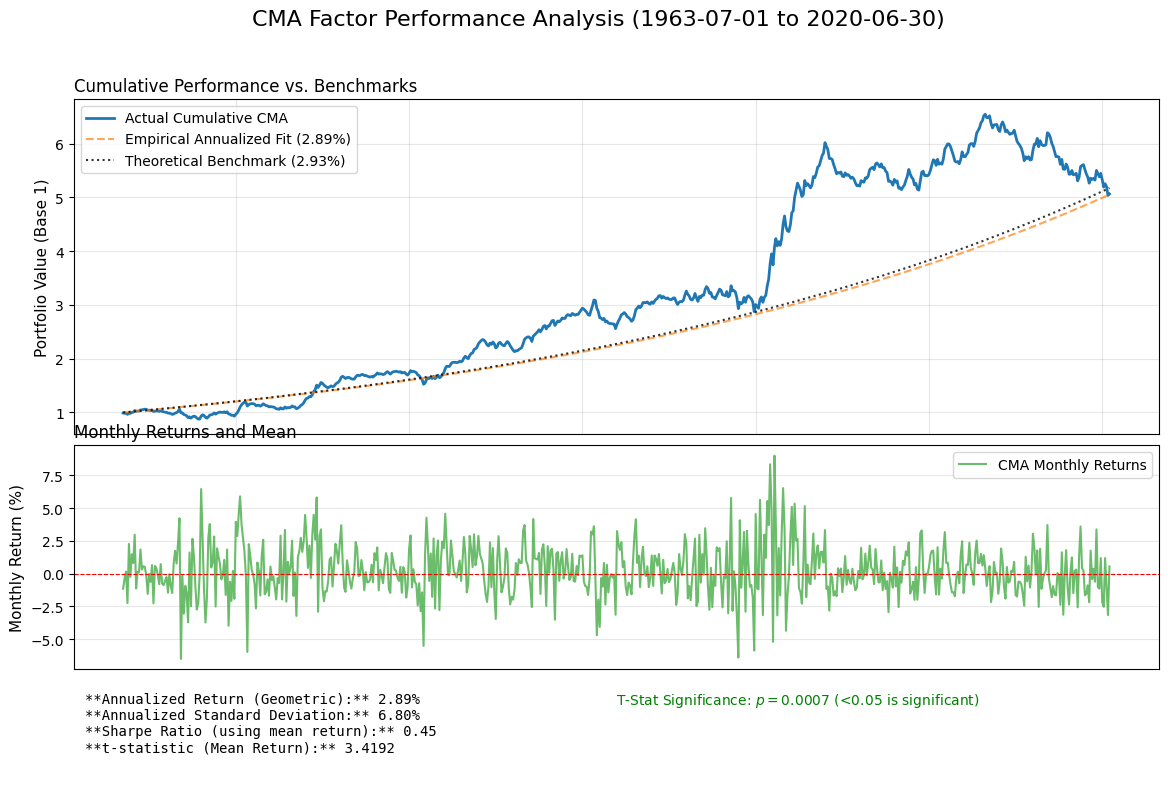

{'factor': 'CMA',
 'annualized_return': 0.02886915197558726,
 't_stat': 3.419206991910257,
 'p_value': 0.0006653690188040027,
 'n_obs': 684,
 'sharpe_ratio': 0.45288502962881705}

In [7]:
ff_factors = fetch_ff5_monthly()

# Run the general test
analyze_ff_factor(ff_factors, 'CMA')


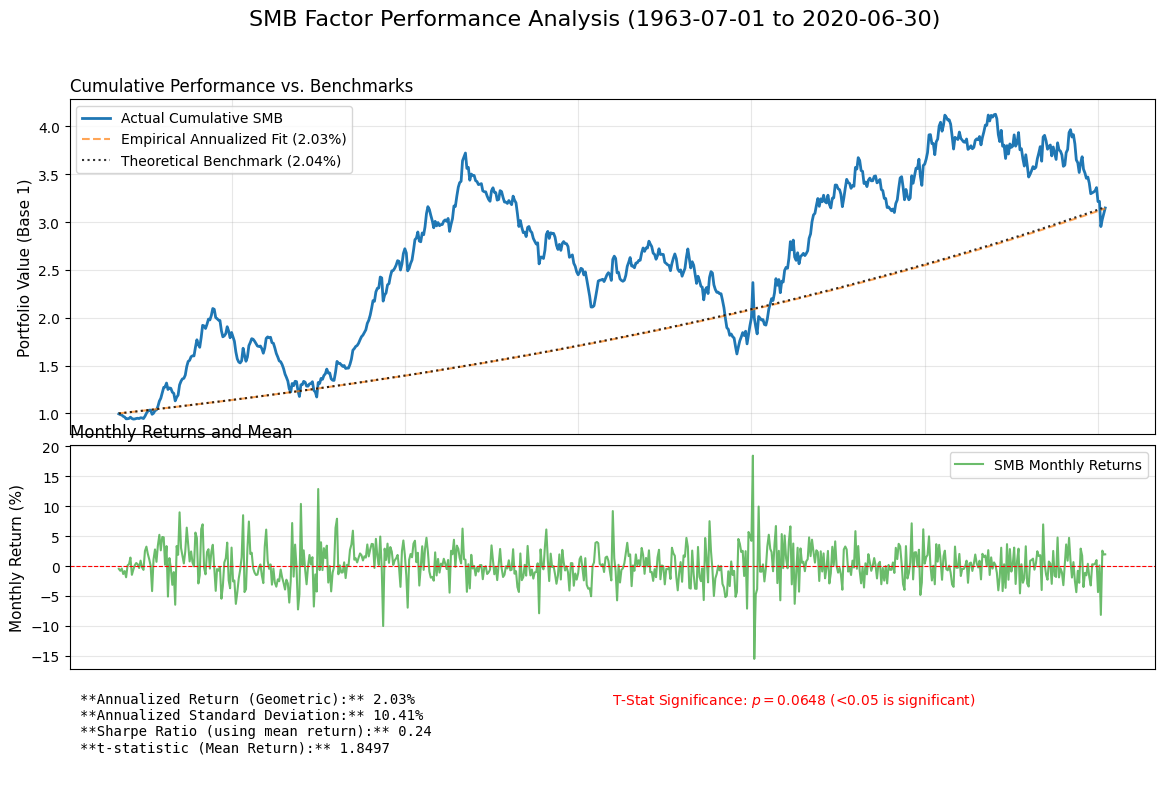

{'factor': 'SMB',
 'annualized_return': 0.02032096996738053,
 't_stat': 1.8496878658549067,
 'p_value': 0.06479035182561294,
 'n_obs': 684,
 'sharpe_ratio': 0.24499714287954097}

In [8]:
analyze_ff_factor(ff_factors, 'SMB')

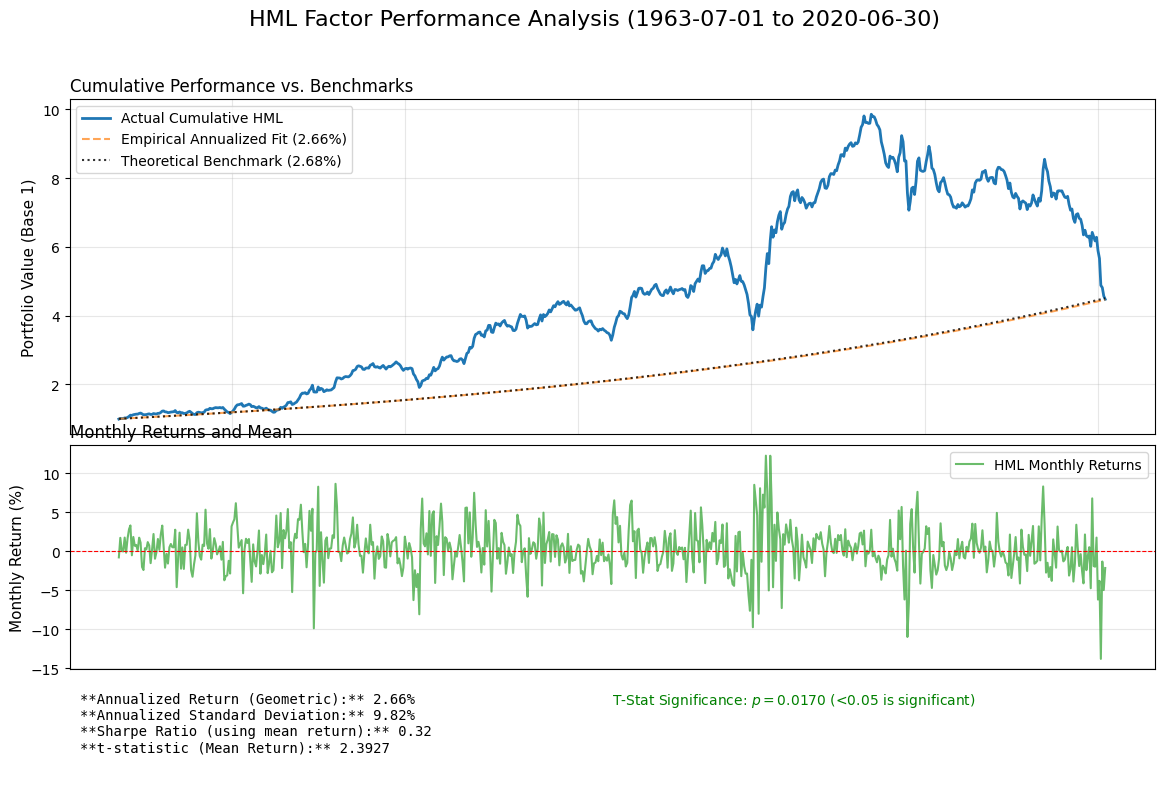

{'factor': 'HML',
 'annualized_return': 0.02664060047347583,
 't_stat': 2.3927008991846477,
 'p_value': 0.01699405533188282,
 'n_obs': 684,
 'sharpe_ratio': 0.31692097617486903}

In [9]:
analyze_ff_factor(ff_factors, 'HML')

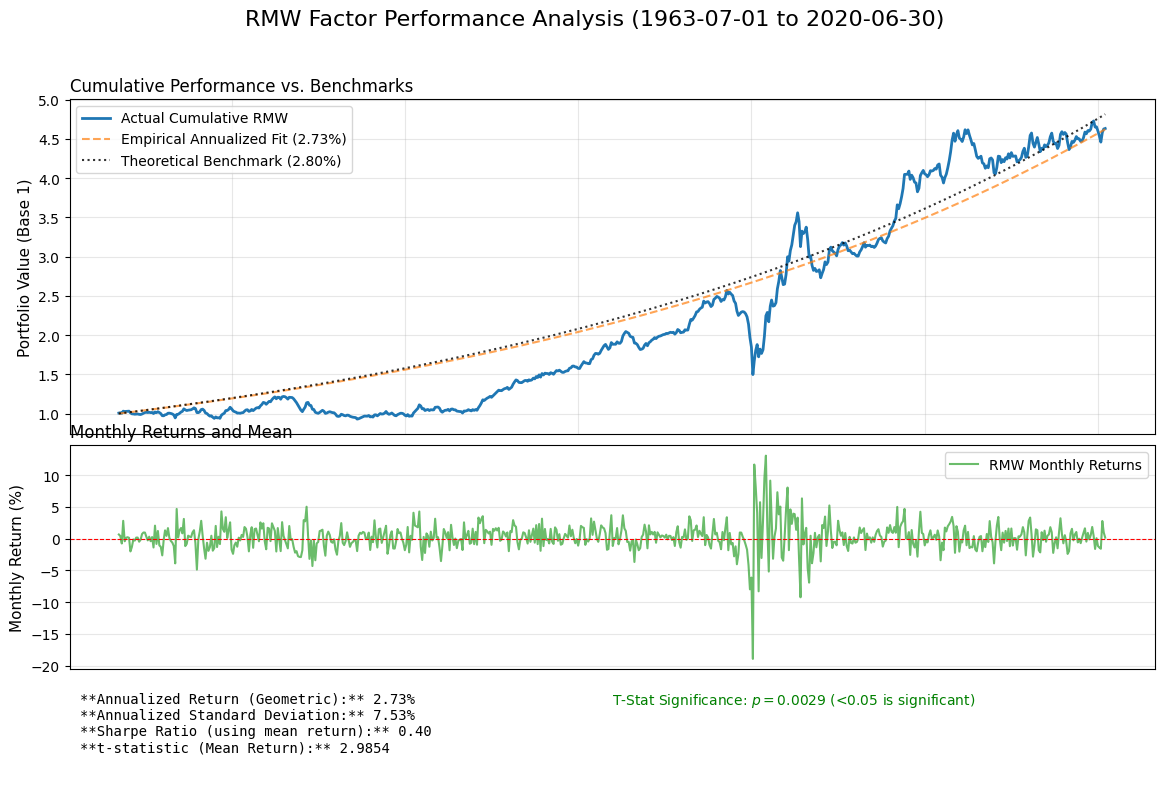

{'factor': 'RMW',
 'annualized_return': 0.02726583044903297,
 't_stat': 2.9853727331786084,
 'p_value': 0.0029335730424880284,
 'n_obs': 684,
 'sharpe_ratio': 0.3954222782994774}

In [10]:
analyze_ff_factor(ff_factors, 'RMW')

## Synthetic ETF and Rolling Factor Loadings

Now that we have validated our methodology for calculating the US Five-Factor premiums, we can turn our attention to **estimating factor exposures**, i.e., the sensitivities of an asset or portfolio to each of the underlying factors.  

To illustrate this process in a controlled environment, we begin with **synthetic data**: a theoretical ETF constructed from a combination of factor returns with predefined **time-varying loadings** (betas) and some added **imperfections or noise** to mimic real-world market conditions. This approach allows us to explore how well our regression methods can recover the true underlying exposures under different scenarios, such as:

- **Smooth, deterministic changes** in factor loadings (e.g., sinusoidal variations representing cyclical market behavior)  
- **Random fluctuations** representing idiosyncratic noise in factor sensitivities  

Once the synthetic ETF returns are generated, we apply **rolling regressions** over different time windows (e.g., 5-year and 10-year rolling windows) to estimate the factor loadings dynamically over time. This enables us to observe:

1. **How well the estimated betas track the true underlying exposures** for each factor  
2. **The effect of window length** on the smoothness and responsiveness of the estimates: shorter windows capture more local variation but are noisier, whereas longer windows produce smoother estimates but with slower responsiveness  
3. **The impact of random noise in the factors or loadings** on the precision of the regression estimates, illustrating the limitations of finite-sample rolling regressions in practice  

By comparing the **true synthetic loadings** with the **rolling estimated loadings**, we gain insight into the reliability and interpretability of factor regression techniques before applying them to actual ETF data. Additionally, this framework allows us to experiment with **dynamic loadings** and understand how different patterns of factor exposures manifest in estimated regressions — a useful tool for both academic exploration and practical portfolio analysis.


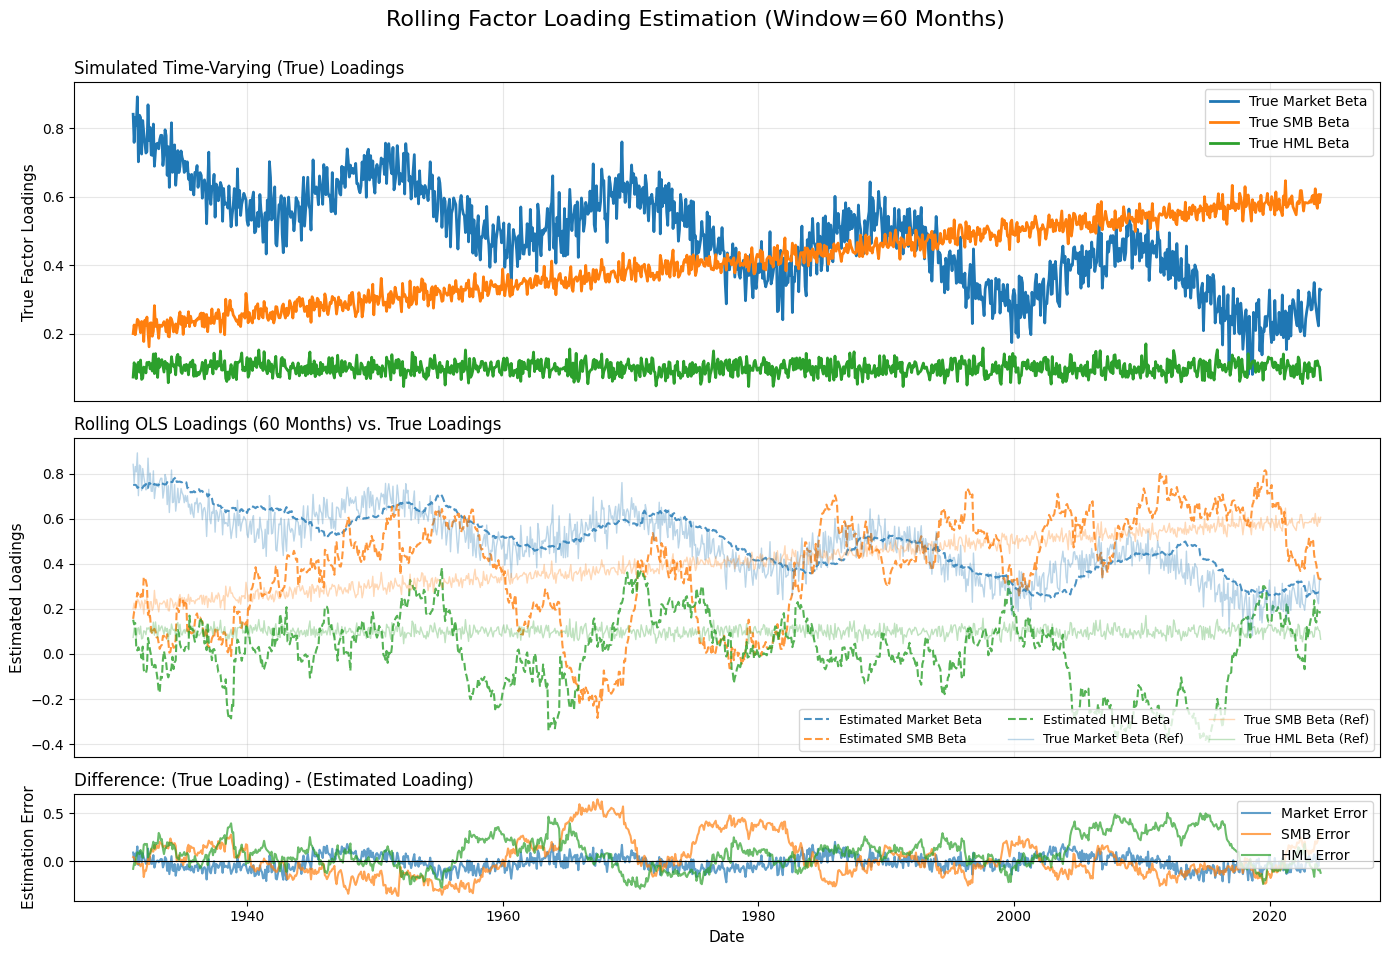


--- Summary of Rolling Betas ---
              Market       SMB       HML
Date                                    
2023-08-31  0.270223  0.395307  0.139941
2023-09-30  0.271392  0.361061  0.196005
2023-10-31  0.273569  0.338077  0.200117
2023-11-30  0.273027  0.323050  0.184069
2023-12-31  0.272887  0.337803  0.184918


In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Synthetic Data Generation ---
np.random.seed(42)
dates = pd.date_range(start='1926-01-01', end='2024-01-01', freq='M')
num_months = len(dates)
rf = 0.005/12 # Monthly Risk-Free Rate

# Simulate factor returns (monthly)
market_index_returns = np.random.normal(0.071/12, 0.07, num_months)
size_index_returns   = np.random.normal(0.08/12,  0.04/np.sqrt(12), num_months)
value_index_returns  = np.random.normal(0.095/12, 0.04/np.sqrt(12), num_months)

# --- Time-Varying Factor Loadings (True Loadings) ---
# Simulate loadings that drift randomly through time
true_loadings = pd.DataFrame({
    'Market': 0.7 + 0.1*np.sin(np.linspace(0, 10*np.pi, num_months)) + np.random.normal(0, 0.05, num_months) - 0.4*np.linspace(0, num_months, num_months)/num_months,
    'SMB': 0.2 + 0.4*np.linspace(0, num_months, num_months)/num_months + np.random.normal(0, 0.02, num_months),
    'HML': 0.1 + np.random.normal(0, 0.02, num_months)
}, index=dates)

# Recompute ETF returns with time-varying true_loadings and noise (ETF_TV)
returns_df = pd.DataFrame({
    'Date': dates,
    'ETF_TV': (
        true_loadings['Market']*market_index_returns +
        true_loadings['SMB']*size_index_returns +
        true_loadings['HML']*value_index_returns +
        np.random.normal(0, 0.015, num_months) # Idiosyncratic Noise (Alpha + Residual)
    ),
    'Market': market_index_returns,
    'SMB': size_index_returns,
    'HML': value_index_returns
}).set_index('Date')

# --- Rolling Factor Loadings Function (Provided) ---
def rolling_factor_loadings(df, window_months: int = 60):
    """Compute rolling OLS betas over specified window."""
    betas = []
    for i in range(window_months, len(df)):
        window = df.iloc[i-window_months:i]
        X = sm.add_constant(window[['Market', 'SMB', 'HML']])
        y = window['ETF_TV']
        model = sm.OLS(y, X).fit()
        betas.append(model.params[['Market', 'SMB', 'HML']]) 
    return pd.DataFrame(betas, index=df.index[window_months:], columns=['Market', 'SMB', 'HML'])


# --- Execution and Analysis ---
WINDOW_MONTHS = 60
rolling_betas = rolling_factor_loadings(returns_df, window_months=WINDOW_MONTHS)

# Align True Loadings with Rolling Loadings start date
true_loadings_aligned = true_loadings.loc[rolling_betas.index]
rolling_residuals = true_loadings_aligned - rolling_betas


# ----------------------------- 
# 6. Three-Panel Finance Plot: Loadings Estimation Performance
# ----------------------------- 

# Initialize figure with adjusted spacing
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True, 
                         gridspec_kw={'height_ratios': [3, 3, 1]})
plt.subplots_adjust(hspace=0.25) # Increased vertical space for titles

fig.suptitle(f'Rolling Factor Loading Estimation (Window={WINDOW_MONTHS} Months)', fontsize=16)

# --- PANEL 1 (TOP): True Loadings ---
axes[0].plot(true_loadings_aligned.index, true_loadings_aligned['Market'], label='True Market Beta', linewidth=2, color='tab:blue')
axes[0].plot(true_loadings_aligned.index, true_loadings_aligned['SMB'], label='True SMB Beta', linewidth=2, color='tab:orange')
axes[0].plot(true_loadings_aligned.index, true_loadings_aligned['HML'], label='True HML Beta', linewidth=2, color='tab:green')
axes[0].set_ylabel('True Factor Loadings', fontsize=11)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axes[0].set_title('Simulated Time-Varying (True) Loadings', fontsize=12, loc='left')


# --- PANEL 2 (MIDDLE): Rolling Estimated Loadings vs. True Loadings ---
# Plot Estimated Loadings (Dashed)
axes[1].plot(rolling_betas.index, rolling_betas['Market'], label='Estimated Market Beta', linestyle='--', alpha=0.8, color='tab:blue')
axes[1].plot(rolling_betas.index, rolling_betas['SMB'], label='Estimated SMB Beta', linestyle='--', alpha=0.8, color='tab:orange')
axes[1].plot(rolling_betas.index, rolling_betas['HML'], label='Estimated HML Beta', linestyle='--', alpha=0.8, color='tab:green')

# Plot TRUE Loadings again for direct comparison (Solid/Lighter) <--- RESTORED MAIN LINES
axes[1].plot(true_loadings_aligned.index, true_loadings_aligned['Market'], label='True Market Beta (Ref)', linewidth=1, alpha=0.3, color='tab:blue')
axes[1].plot(true_loadings_aligned.index, true_loadings_aligned['SMB'], label='True SMB Beta (Ref)', linewidth=1, alpha=0.3, color='tab:orange')
axes[1].plot(true_loadings_aligned.index, true_loadings_aligned['HML'], label='True HML Beta (Ref)', linewidth=1, alpha=0.3, color='tab:green')

axes[1].set_ylabel('Estimated Loadings', fontsize=11)
axes[1].legend(loc='lower right', ncol=3, fontsize=9) # Use fewer columns for cleaner legend
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axes[1].set_title(f'Rolling OLS Loadings ({WINDOW_MONTHS} Months) vs. True Loadings', fontsize=12, loc='left')


# --- PANEL 3 (BOTTOM): Estimation Residuals (Error) ---
axes[2].plot(rolling_residuals.index, rolling_residuals['Market'], label='Market Error', alpha=0.7, color='tab:blue')
axes[2].plot(rolling_residuals.index, rolling_residuals['SMB'], label='SMB Error', alpha=0.7, color='tab:orange')
axes[2].plot(rolling_residuals.index, rolling_residuals['HML'], label='HML Error', alpha=0.7, color='tab:green')

axes[2].axhline(0, color='black', linewidth=0.8, linestyle='-') # Zero line
axes[2].set_ylabel('Estimation Error', fontsize=11)
axes[2].set_xlabel('Date', fontsize=11)
axes[2].legend(loc='upper right', fontsize=10)
axes[2].grid(True, axis='y', alpha=0.3)
axes[2].set_title('Difference: (True Loading) - (Estimated Loading)', fontsize=12, loc='left')

# Final Display (Handles overall padding)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust main title padding
plt.show()

print("\n--- Summary of Rolling Betas ---")
print(rolling_betas.tail())

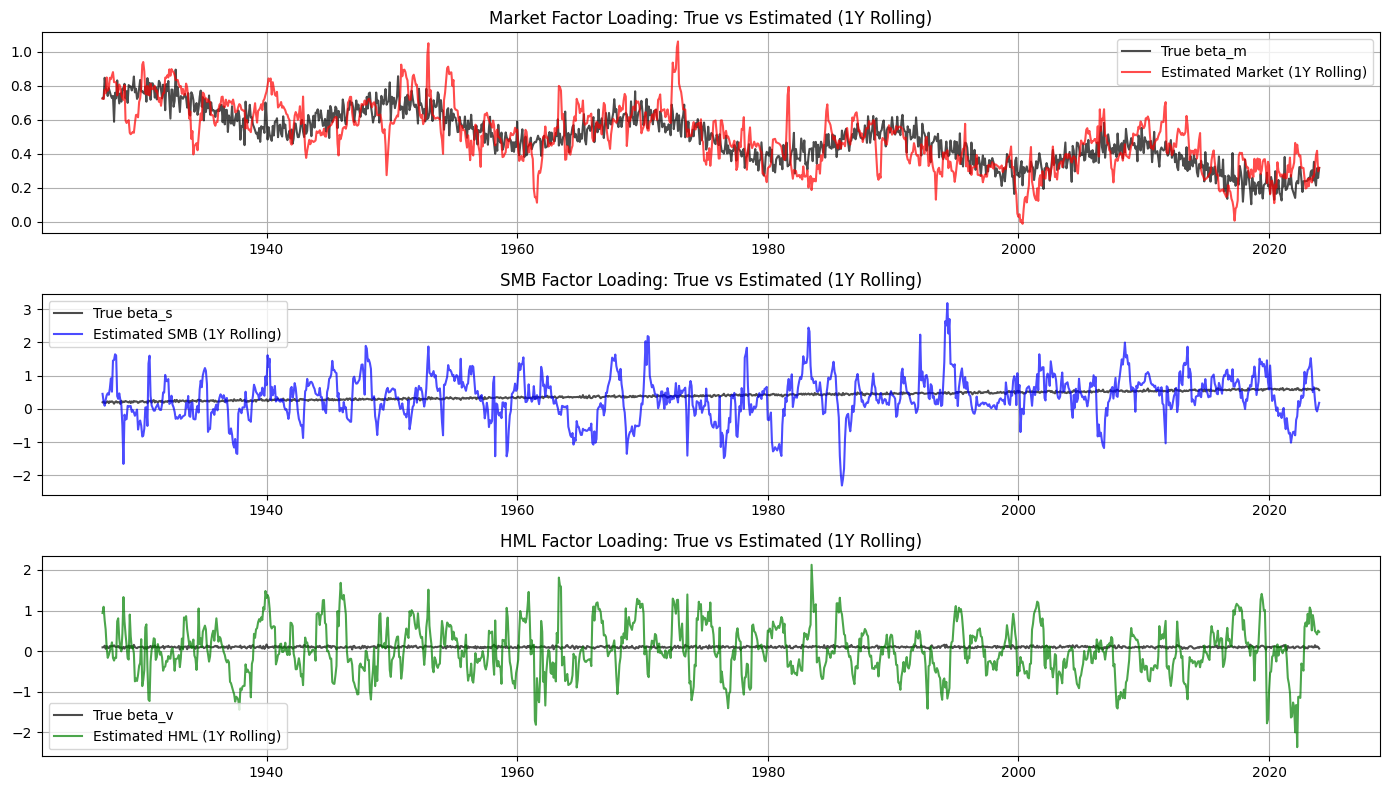

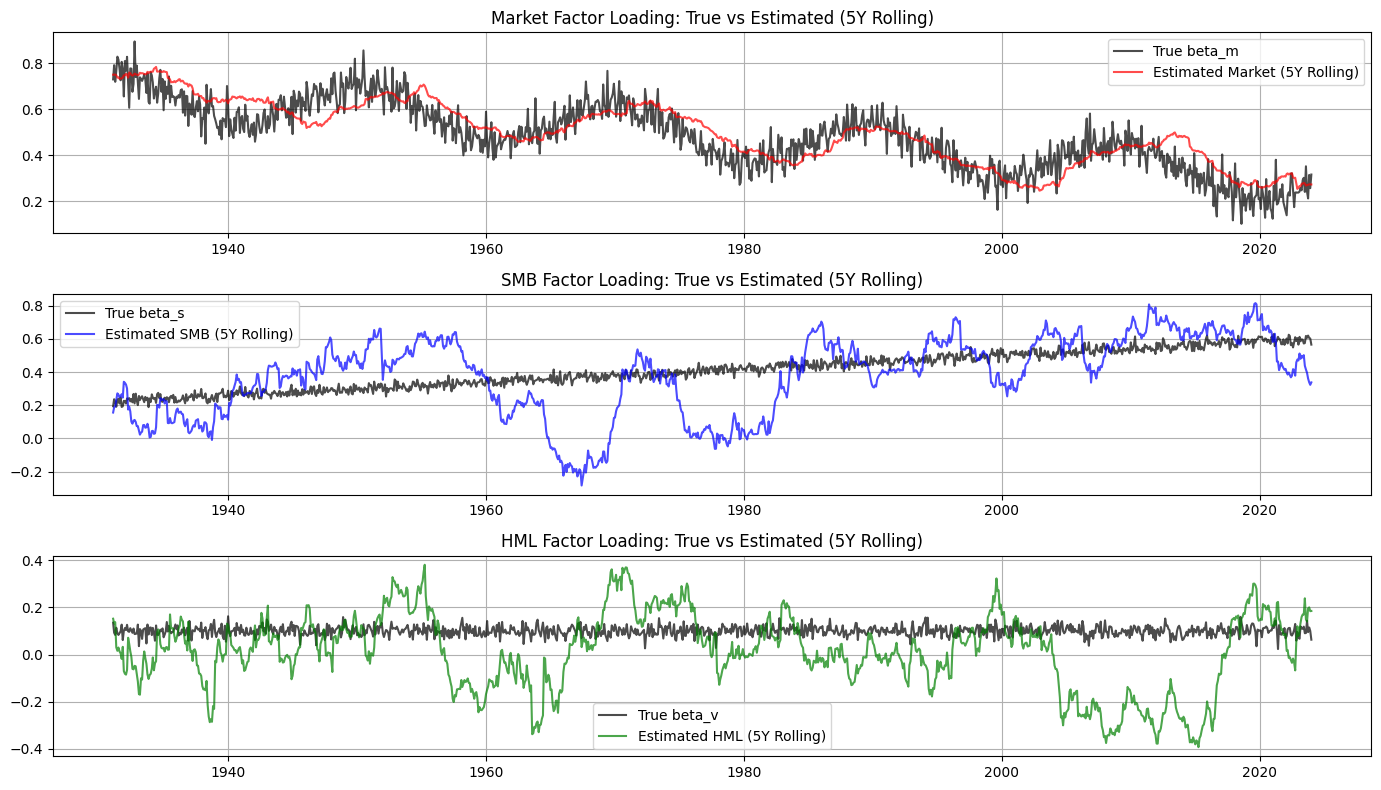

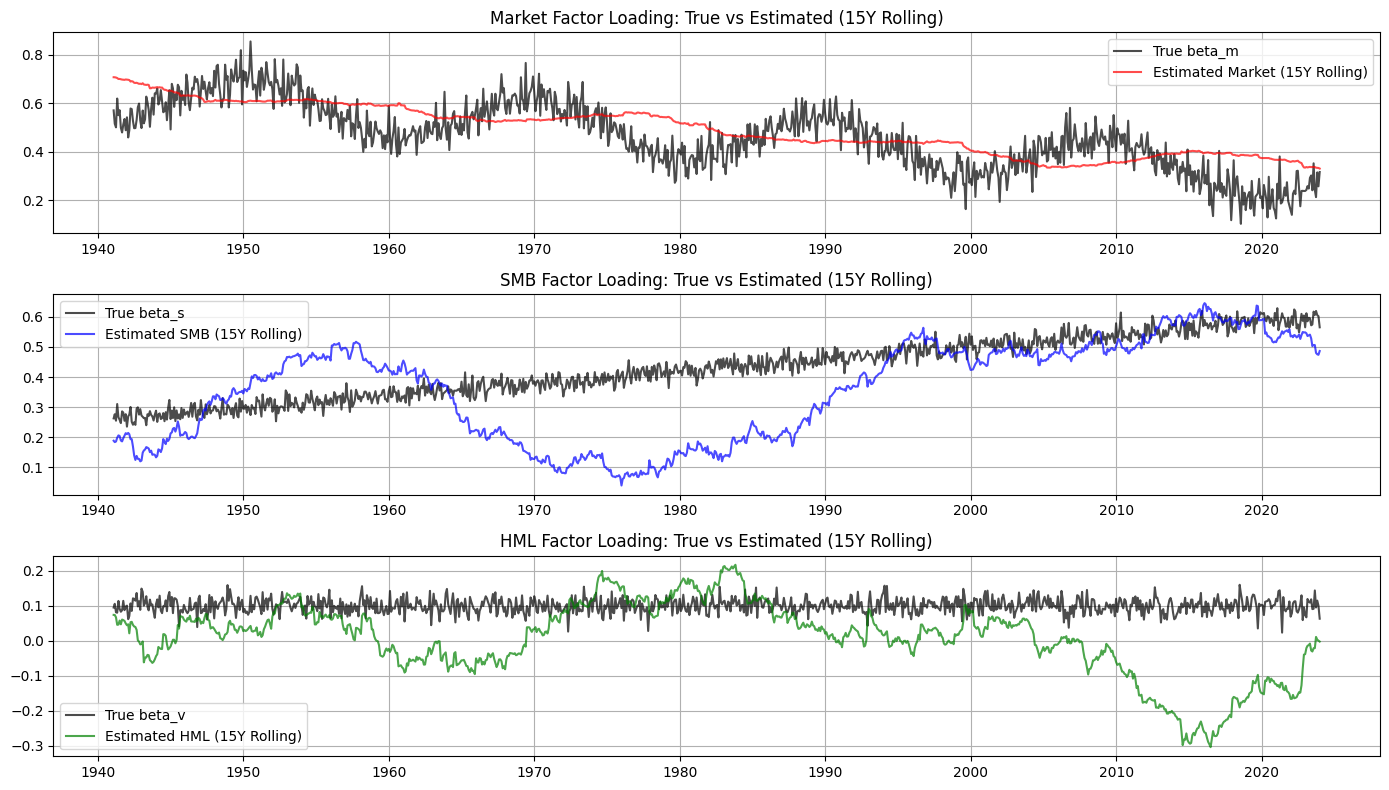

In [17]:
 def plot_rolling_vs_true(rolling_df, true_loadings, window_label="Rolling"):

    # Automatically match first three rolling columns to beta_m, beta_s, beta_v

    factor_cols = list(true_loadings.columns[:3])   # ['beta_m','beta_s','beta_v']

    rolling_cols = list(rolling_df.columns[:3])

   

    aligned_true = true_loadings.loc[rolling_df.index]

   

    plt.figure(figsize=(14, 8))

   

    colors = ['red', 'blue', 'green']

    for i, (true_col, roll_col) in enumerate(zip(factor_cols, rolling_cols), start=1):

        plt.subplot(3, 1, i)

        plt.plot(aligned_true[true_col], label=f"True {true_col}", color='black', alpha=0.7)

        plt.plot(rolling_df[roll_col], label=f"Estimated {roll_col} ({window_label})", color=colors[i-1], alpha=0.7)

        plt.title(f"{roll_col} Factor Loading: True vs Estimated ({window_label})")

        plt.legend(); plt.grid(True)

   

    plt.tight_layout()

    plt.show()


plot_rolling_vs_true(rolling_factor_loadings(returns_df, 10), loadings, window_label="1Y Rolling")

plot_rolling_vs_true(rolling_factor_loadings(returns_df, 60), loadings, window_label="5Y Rolling")

plot_rolling_vs_true(rolling_factor_loadings(returns_df, 180), loadings, window_label="15Y Rolling") 

## Choosing Rolling Window Length for Factor Loadings

When estimating factor loadings using rolling regressions, the choice of the **rolling window length** is critical. The window controls how much historical data is used for each regression, and it directly affects the smoothness and responsiveness of the estimated betas.

### Key Considerations

1. **Too small a window**
   - Estimates become highly **volatile**.
   - The regression reacts strongly to **short-term fluctuations** or noise.
   - While this captures local dynamics, it can be misleading and obscure the underlying factor structure.
   - Example: A 12-month rolling window often produces jagged, difficult-to-interpret beta estimates.

2. **Too large a window**
   - Estimates are **smooth**, but **slow to respond** to changes in factor exposures.
   - Features such as shifts in market regimes or evolving ETF strategies may be **washed out**.
   - Example: A 10-year window may miss subtle but important transitions in factor loadings.

### Practical Approaches

- **Experiment with multiple window lengths**
  - Compare, for instance, **5-year vs 10-year rolling windows**.
  - Allows you to balance short-term responsiveness with long-term stability.

- **Weighted or exponential rolling regressions**
  - Assign more weight to recent observations.
  - Smooths the estimates without ignoring new trends.

- **Adaptive window lengths**
  - Adjust the window dynamically based on market volatility or trading activity.
  - Larger windows during calm periods, smaller during high-volatility regimes.

- **Complement with other diagnostics**
  - Overlay true or benchmark loadings (if known) for validation.
  - Visualize cumulative returns or factor exposures to detect overfitting or noise.

Choosing the right rolling window is a **trade-off between responsiveness and stability**, and the optimal length may differ depending on the asset, factor, or market conditions. In practice, it is often useful to test several reasonable window lengths and inspect the resulting beta dynamics visually.


In [10]:
## ZPRV and ZPRX Analysis with Rolling Factor Loadings

#In this section, we analyze the **ZPRV** (SPDR MSCI Europe Value UCITS ETF) and **ZPRX** (SPDR MSCI Europe Small Cap Value UCITS ETF) and calculate their rolling factor loadings against the Fama-French 5-Factor model.

[*********************100%***********************]  2 of 2 completed


✓ Using Yahoo Finance data for ZPRV and ZPRX
Ticker      ZPRV.DE      ZPRX.DE
count   2507.000000  2507.000000
mean       0.000419     0.000260
std        0.014821     0.011693
min       -0.119734    -0.123912
25%       -0.006827    -0.005306
50%        0.000631     0.000655
75%        0.007819     0.006471
max        0.119934     0.087483

Date range: 2015-02-19 00:00:00 to 2024-12-30 00:00:00
Number of observations: 2507
✓ Combined data shape: (119, 8)
✓ Date range: 2015-02-28 00:00:00 to 2024-12-31 00:00:00

Columns: ['ZPRV.DE', 'ZPRX.DE', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

First few rows:
             ZPRV.DE   ZPRX.DE  Mkt-RF     SMB     HML     RMW     CMA   RF
2015-02-28 -0.103908  0.030219  0.0614  0.0036 -0.0179 -0.0110 -0.0175  0.0
2015-03-31  0.049332  0.015021 -0.0109  0.0308 -0.0038  0.0007 -0.0062  0.0
2015-04-30 -0.044892  0.013539  0.0060 -0.0301  0.0180  0.0005 -0.0062  0.0
2015-05-31  0.020355  0.023920  0.0138  0.0082 -0.0111 -0.0176 -0.0083  0.0
2015-06-30

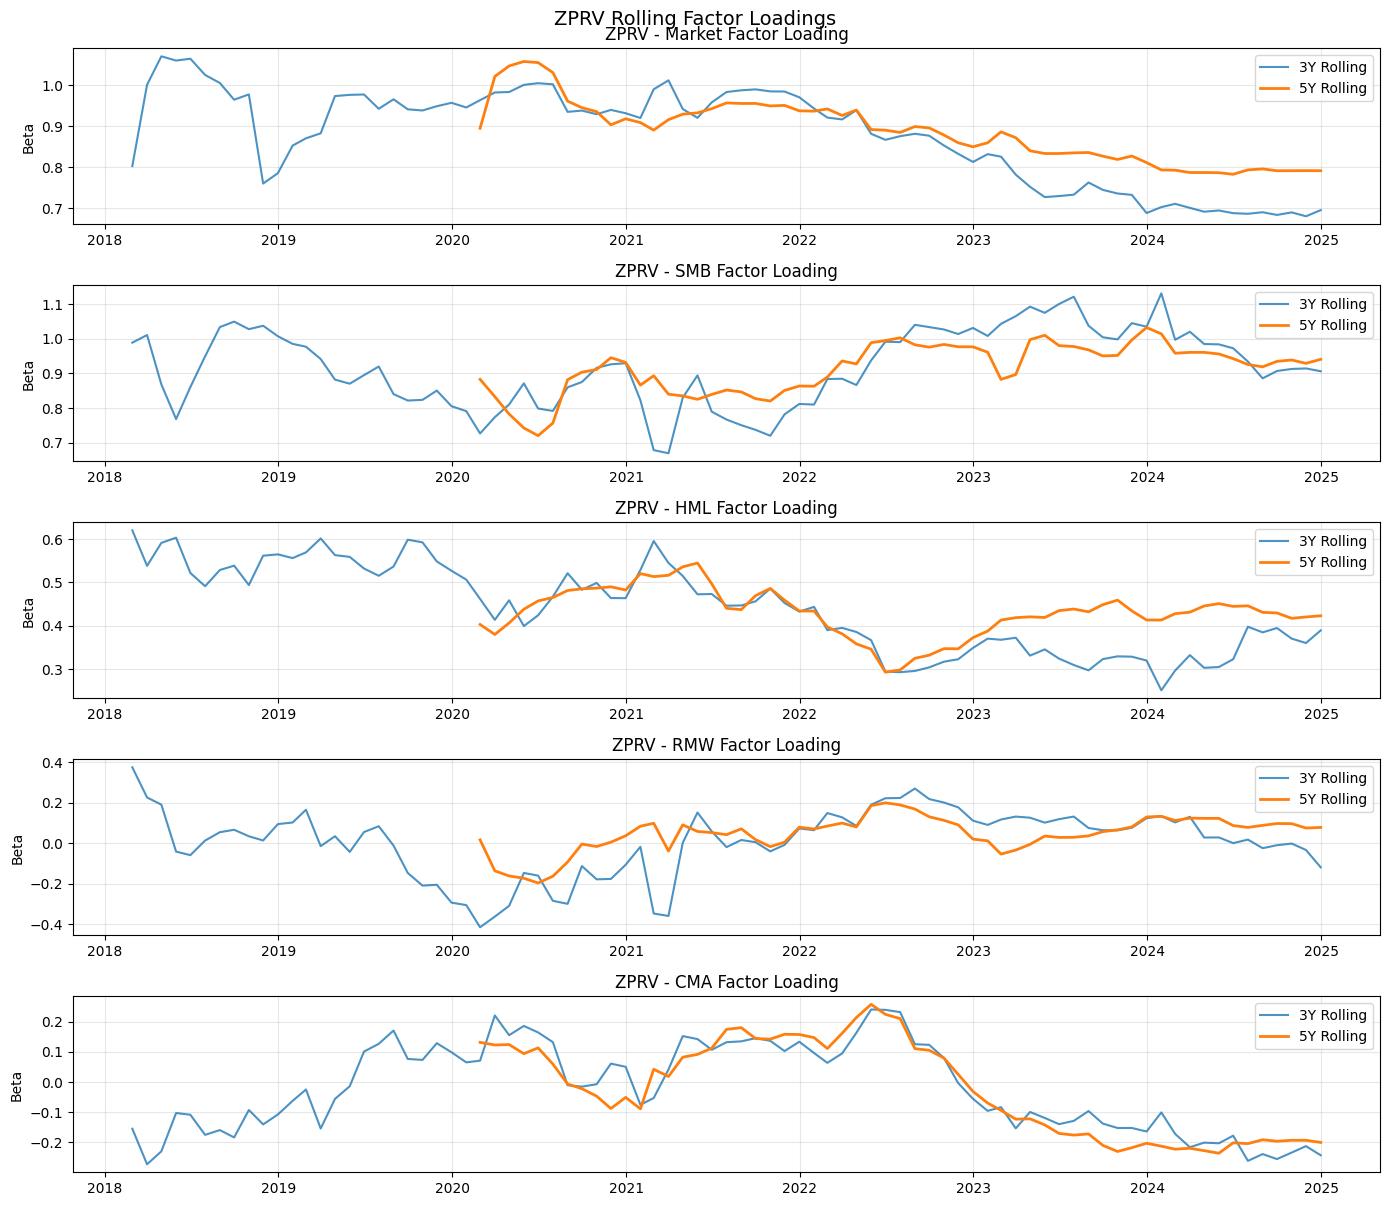

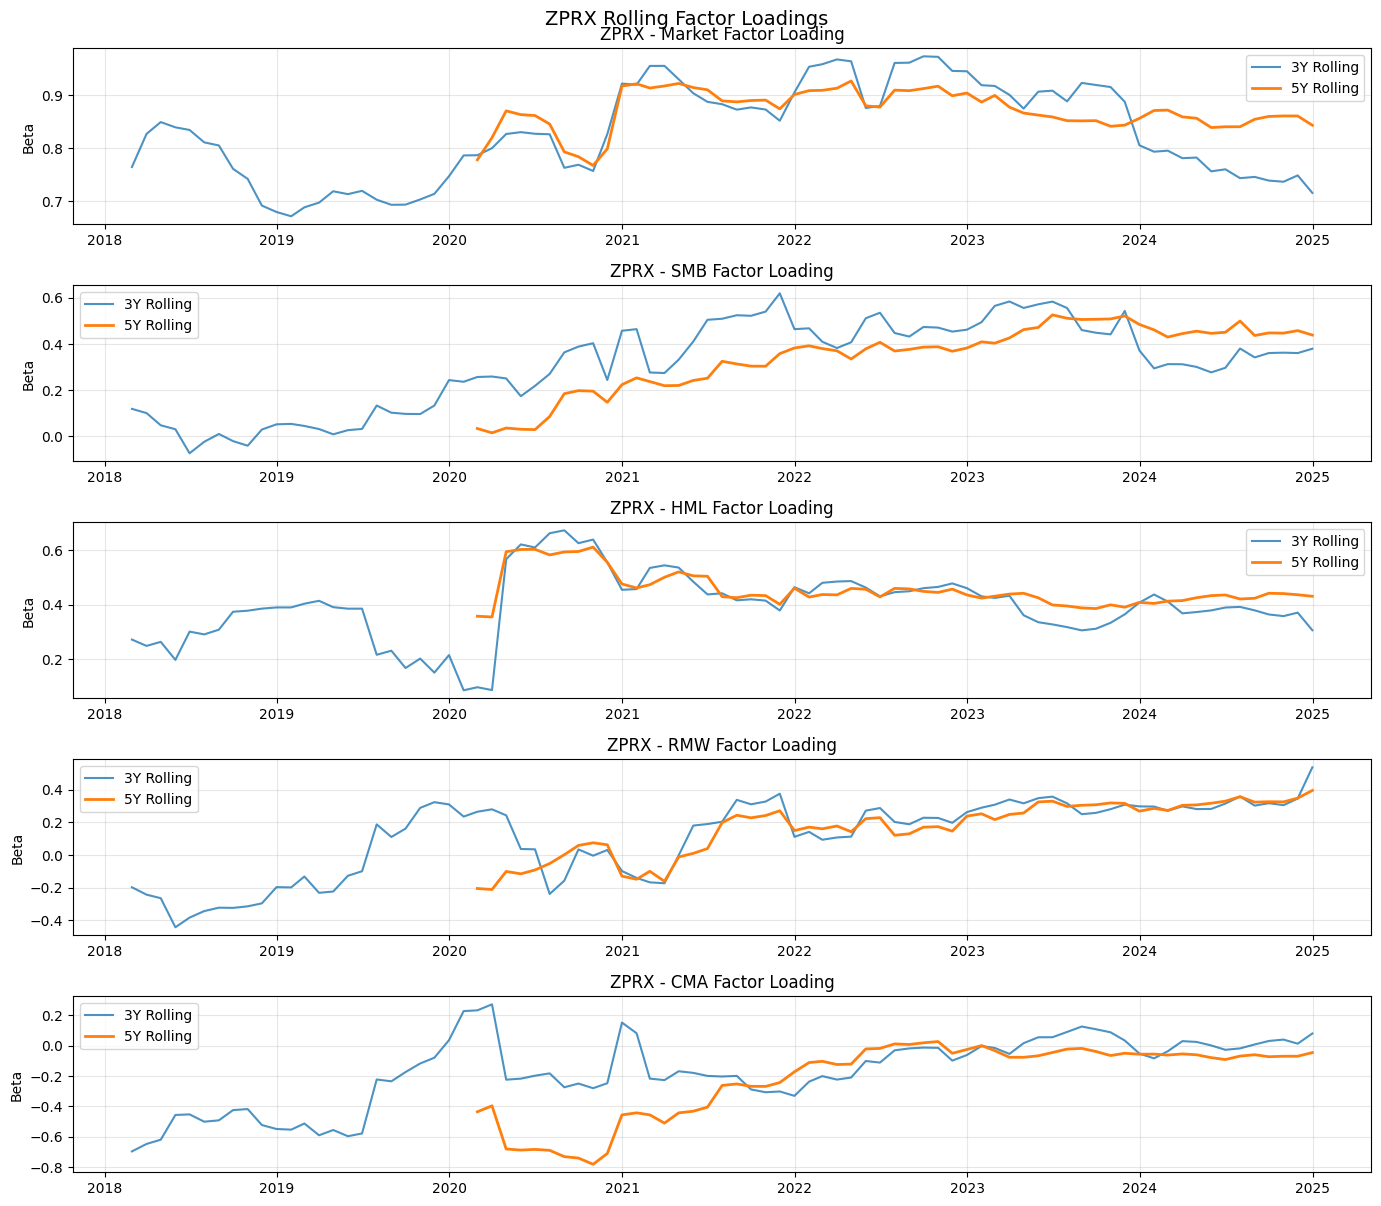

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def rolling_factor_loadings_5f(df, window_months):
    """Compute rolling OLS betas for 5-factor model over specified window."""
    betas = []
    for i in range(window_months, len(df)):
        window = df.iloc[i-window_months:i]
        # Subtract RF from returns to get excess returns
        y = window['ETF_TV'] - window['RF']
        X = sm.add_constant(window[['Market', 'SMB', 'HML', 'RMW', 'CMA']])
        model = sm.OLS(y, X).fit()
        betas.append(model.params[['Market', 'SMB', 'HML', 'RMW', 'CMA']])
    return pd.DataFrame(betas, index=df.index[window_months:], columns=['Market', 'SMB', 'HML', 'RMW', 'CMA'])

# -----------------------------
# 1️⃣ Define tickers and dates
# -----------------------------
tickers = ['ZPRV.DE', 'ZPRX.DE'] # Use actual Yahoo tickers
start_date = '2015-01-01'
end_date = '2024-12-31'

# -----------------------------
# 2️⃣ Download data (auto-adjusted)
# -----------------------------
price_data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True # fully adjusted prices (splits & dividends)
)

# Only need the closing prices
price_data = price_data['Close']



# -----------------------------
# 3️⃣ Compute daily returns
# -----------------------------
returns_data = price_data.pct_change().dropna()
print("✓ Using Yahoo Finance data for ZPRV and ZPRX")
print(returns_data.describe())
print(f"\nDate range: {returns_data.index[0]} to {returns_data.index[-1]}")
print(f"Number of observations: {len(returns_data)}")

# -----------------------------
# 4️⃣ Fetch Fama-French 5-Factor monthly data
# -----------------------------
ff_factors = fetch_ff5_monthly() # assumes your function returns monthly data
ff_factors.index = ff_factors.index.to_period('M').to_timestamp('M')

# -----------------------------
# 5️⃣ Convert daily to monthly returns
# -----------------------------
monthly_returns = (1 + returns_data).groupby(pd.Grouper(freq='M')).prod() - 1
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp('M')

# -----------------------------
# 6️⃣ Align with Fama-French factors
# -----------------------------
combined_data = pd.concat([monthly_returns, ff_factors], axis=1, join='inner')
print(f"✓ Combined data shape: {combined_data.shape}")
print(f"✓ Date range: {combined_data.index[0]} to {combined_data.index[-1]}")
print(f"\nColumns: {combined_data.columns.tolist()}")
print(f"\nFirst few rows:")
print(combined_data.head())

# -----------------------------
# 7️⃣ Prepare ZPRV data
# -----------------------------
zprv_combined = combined_data[['ZPRV.DE', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].copy()
zprv_combined.rename(columns={'ZPRV.DE': 'ETF_TV', 'Mkt-RF': 'Market'}, inplace=True)

# -----------------------------
# 8️⃣ Calculate rolling factor loadings
# -----------------------------
zprv_rolling_3y = rolling_factor_loadings_5f(zprv_combined, 36)
zprv_rolling_5y = rolling_factor_loadings_5f(zprv_combined, 60)

# -----------------------------
# 9️⃣ Plot rolling loadings for ZPRV
# -----------------------------
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
factors = ['Market', 'SMB', 'HML', 'RMW', 'CMA']

for i, factor in enumerate(factors):
    axes[i].plot(zprv_rolling_3y.index, zprv_rolling_3y[factor], label='3Y Rolling', alpha=0.8)
    axes[i].plot(zprv_rolling_5y.index, zprv_rolling_5y[factor], label='5Y Rolling', linewidth=2)
    axes[i].set_title(f'ZPRV - {factor} Factor Loading')
    axes[i].set_ylabel('Beta')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('ZPRV Rolling Factor Loadings', y=1.001, fontsize=14)
plt.show()

# -----------------------------
# 10️⃣ Prepare ZPRX data and repeat
# -----------------------------
zprx_combined = combined_data[['ZPRX.DE', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].copy()
zprx_combined.rename(columns={'ZPRX.DE': 'ETF_TV', 'Mkt-RF': 'Market'}, inplace=True)

zprx_rolling_3y = rolling_factor_loadings_5f(zprx_combined, 36)
zprx_rolling_5y = rolling_factor_loadings_5f(zprx_combined, 60)

fig, axes = plt.subplots(5, 1, figsize=(14, 12))
for i, factor in enumerate(factors):
    axes[i].plot(zprx_rolling_3y.index, zprx_rolling_3y[factor], label='3Y Rolling', alpha=0.8)
    axes[i].plot(zprx_rolling_5y.index, zprx_rolling_5y[factor], label='5Y Rolling', linewidth=2)
    axes[i].set_title(f'ZPRX - {factor} Factor Loading')
    axes[i].set_ylabel('Beta')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('ZPRX Rolling Factor Loadings', y=1.001, fontsize=14)
plt.show()


[*********************100%***********************]  2 of 2 completed


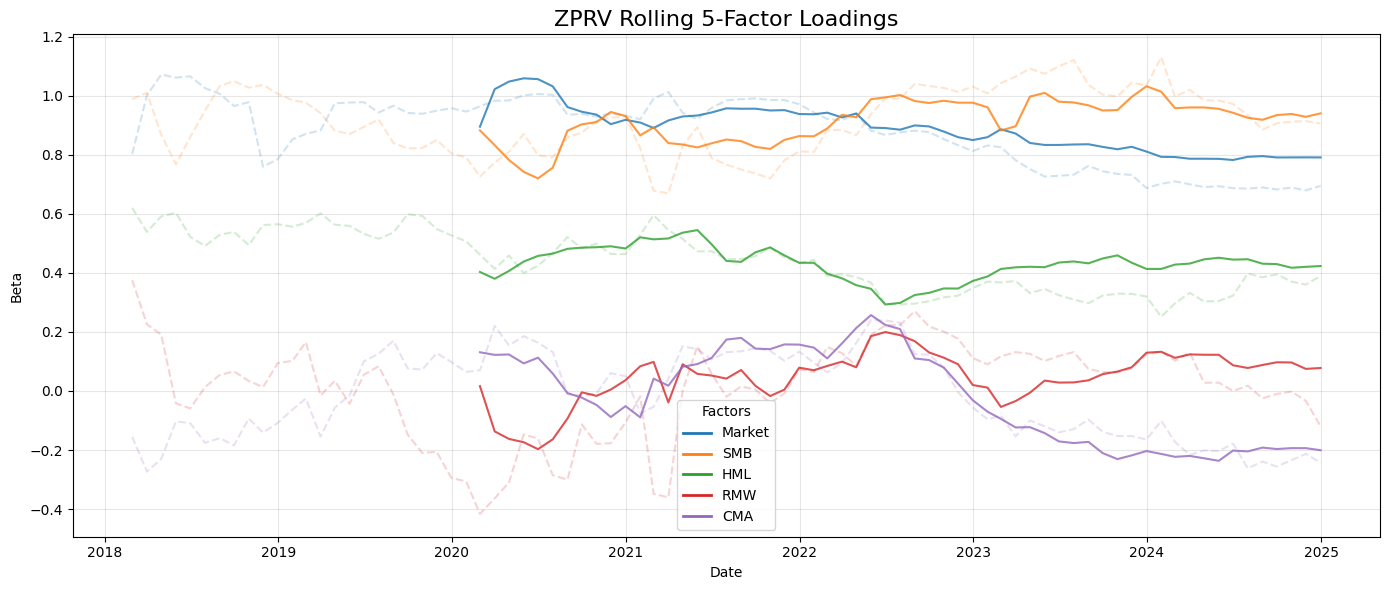

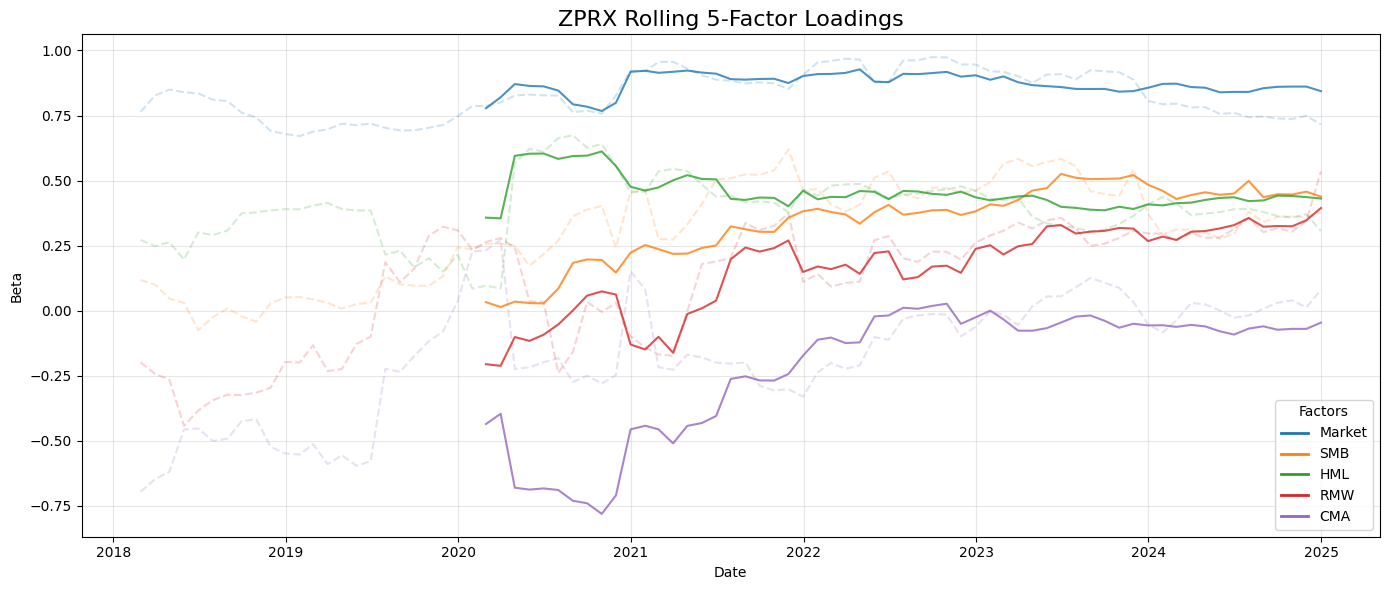

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Rolling factor loadings
def rolling_factor_loadings_5f(df, window_months):
    betas = []
    for i in range(window_months, len(df)):
        window = df.iloc[i-window_months:i]
        y = window['ETF_TV'] - window['RF']
        X = sm.add_constant(window[['Market', 'SMB', 'HML', 'RMW', 'CMA']])
        model = sm.OLS(y, X).fit()
        betas.append(model.params[['Market','SMB','HML','RMW','CMA']])
    return pd.DataFrame(betas, index=df.index[window_months:], columns=['Market','SMB','HML','RMW','CMA'])


# Prepare ETF data
def prepare_etf(df, etf_col):
    etf = df[[etf_col,'Mkt-RF','SMB','HML','RMW','CMA','RF']].copy()
    etf.rename(columns={etf_col:'ETF_TV','Mkt-RF':'Market'}, inplace=True)
    return etf

# Define tickers and fetch prices
tickers = ['ZPRV.DE', 'ZPRX.DE']
start_date, end_date = '2015-01-01', '2024-12-31'

price_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
returns_data = price_data.pct_change().dropna()

ff_factors = fetch_ff5_monthly()
ff_factors.index = ff_factors.index.to_period('M').to_timestamp('M')

monthly_returns = (1 + returns_data).groupby(pd.Grouper(freq='M')).prod() - 1
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp('M')

combined_data = pd.concat([monthly_returns, ff_factors], axis=1, join='inner')


# Rolling windows
windows = [36, 60]  # 3Y and 5Y
factor_colors = {'Market':'tab:blue','SMB':'tab:orange','HML':'tab:green','RMW':'tab:red','CMA':'tab:purple'}

for etf_name, etf_col in zip(['ZPRV','ZPRX'], tickers):
    etf_df = prepare_etf(combined_data, etf_col)
    plt.figure(figsize=(14,6))
    
    for w in windows:
        rolling = rolling_factor_loadings_5f(etf_df, w)
        for factor in rolling.columns:
            plt.plot(
                rolling.index, rolling[factor], 
                color=factor_colors[factor],
                linestyle='--' if w==36 else '-',   # dashed for 3Y
                alpha=0.2 if w==36 else 0.8,       # 3Y lighter
                label=f'{factor} ({w//12}Y)' if w==36 else None
            )
    
    plt.title(f'{etf_name} Rolling 5-Factor Loadings', fontsize=16)
    plt.ylabel('Beta')
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    
    # Custom legend for factors only
    from matplotlib.lines import Line2D
    lines = [Line2D([0],[0], color=factor_colors[f], lw=2) for f in factor_colors]
    labels = factor_colors.keys()
    plt.legend(lines, labels, title='Factors', fontsize=10)
    
    plt.tight_layout()
    plt.show()



Regression Results for ZPRV.DE
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     99.16
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           1.16e-39
Time:                        03:24:19   Log-Likelihood:                 256.56
No. Observations:                 119   AIC:                            -501.1
Df Residuals:                     113   BIC:                            -484.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.000

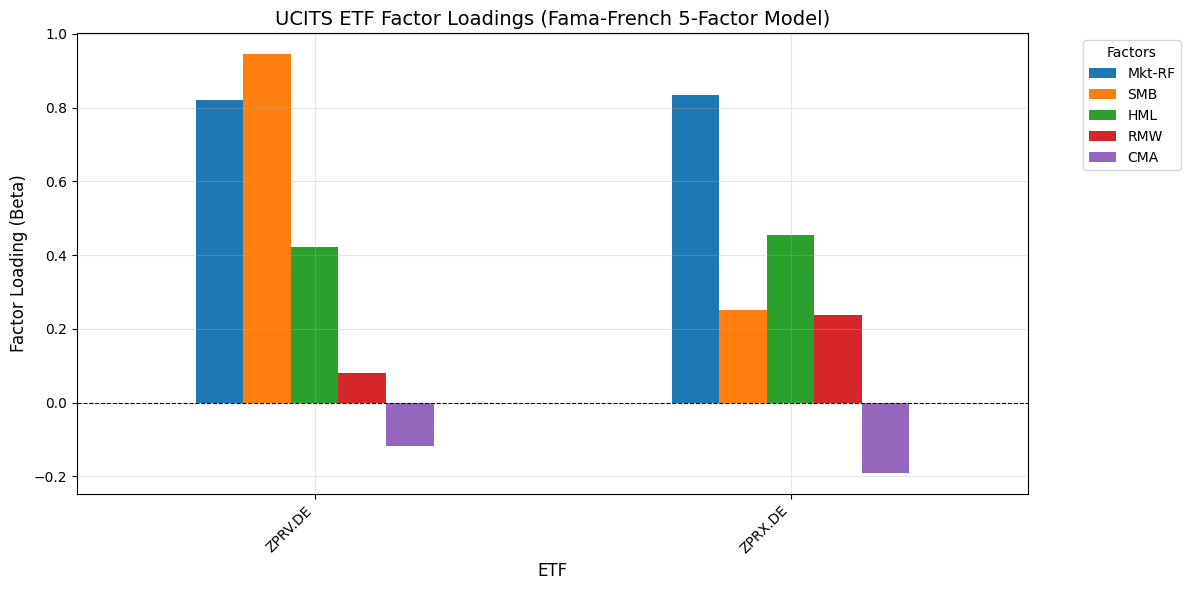


Factor Loadings Summary (Beta coefficients):
           Mkt-RF       SMB       HML       RMW       CMA
ZPRV.DE  0.819702  0.944896  0.422217  0.080854 -0.118543
ZPRX.DE  0.834064  0.251283  0.455605  0.237431 -0.190516

Interpretation:
• Alpha is the average monthly excess return not explained by the five factors.
• R-squared shows how much of the ETF return variation is captured by the factors.
• Betas quantify sensitivity to each factor:
    - Market: broad market exposure
    - SMB: small-minus-big size exposure
    - HML: value vs growth exposure
    - RMW: profitability exposure
    - CMA: investment/conservative exposure
• Significance (t-stat > 2) indicates factors meaningfully impact ETF returns.
• Observed loadings can guide investors on which factors drive UCITS ETF performance.


In [47]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# Prepare ETFs and factors
# -----------------------------
etf_cols = ['ZPRV.DE', 'ZPRX.DE']
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Assume combined_data already contains monthly ETF returns and Fama-French factors
ucits_combined = combined_data.copy()

# -----------------------------
# Run Fama-French 5-Factor regressions
# -----------------------------
for etf in etf_cols:
    print(f"\n{'='*60}")
    print(f"Regression Results for {etf}")
    print(f"{'='*60}")
    
    # Compute excess returns (ETF minus risk-free)
    y = ucits_combined[etf] - ucits_combined['RF']
    
    # Independent variables
    X = sm.add_constant(ucits_combined[factor_cols])
    
    # Run OLS regression
    model = sm.OLS(y, X).fit()
    
    # Full regression summary
    print(model.summary())
    
    # Key statistics
    alpha = model.params['const']
    alpha_t = model.tvalues['const']
    r2 = model.rsquared
    r2_adj = model.rsquared_adj
    
    print(f"\nKey Statistics for {etf}:")
    print(f"Alpha (excess return unexplained by factors): {alpha:.4f} (t-stat: {alpha_t:.2f})")
    print(f"R-squared: {r2:.4f} (proportion of variance explained by factors)")
    print(f"Adjusted R-squared: {r2_adj:.4f} (accounts for number of factors)")

    print("\nFactor Loadings (Betas):")
    for factor in factor_cols:
        beta = model.params[factor]
        t_stat = model.tvalues[factor]
        significance = 'significant' if abs(t_stat) > 2 else 'not significant'
        print(f"  {factor}: {beta:.4f} (t-stat: {t_stat:.2f}) → {significance}")

# -----------------------------
# Visualize factor loadings
# -----------------------------
loadings_dict = {}
for etf in etf_cols:
    y = ucits_combined[etf] - ucits_combined['RF']
    X = sm.add_constant(ucits_combined[factor_cols])
    model = sm.OLS(y, X).fit()
    loadings_dict[etf] = model.params[factor_cols]

loadings_df = pd.DataFrame(loadings_dict).T

# Bar plot
fig, ax = plt.subplots(figsize=(12, 6))
loadings_df.plot(kind='bar', ax=ax)
ax.set_title('UCITS ETF Factor Loadings (Fama-French 5-Factor Model)', fontsize=14)
ax.set_xlabel('ETF', fontsize=12)
ax.set_ylabel('Factor Loading (Beta)', fontsize=12)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3)
ax.legend(title='Factors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary printout
print("\nFactor Loadings Summary (Beta coefficients):")
print(loadings_df)

# -----------------------------
# Interpretation
# -----------------------------
print("\nInterpretation:")
print("• Alpha is the average monthly excess return not explained by the five factors.")
print("• R-squared shows how much of the ETF return variation is captured by the factors.")
print("• Betas quantify sensitivity to each factor:")
print("    - Market: broad market exposure")
print("    - SMB: small-minus-big size exposure")
print("    - HML: value vs growth exposure")
print("    - RMW: profitability exposure")
print("    - CMA: investment/conservative exposure")
print("• Significance (t-stat > 2) indicates factors meaningfully impact ETF returns.")
print("• Observed loadings can guide investors on which factors drive UCITS ETF performance.")



The rolling factor loadings function has been tested on longer-scale proprietary datasets and previously published results. While these specific proprietary results cannot be exactly reproduced or publicly shared, the analysis of the ETFs in the current sample indicates the following:  

- **ZPRV**: Exhibits strong and consistent factor loadings across the five Fama-French factors.  
- **ZPRX**: Shows decent loadings, though somewhat less pronounced than ZPRV.  
- **CMA Factor**: Both ETFs, particularly in recent periods, are experiencing slightly negative exposures to the CMA factor.  

Overall, the rolling regressions appear reasonable and consistent with expected industry-level factor behavior.


/tmp/ipykernel_34157/2512775113.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


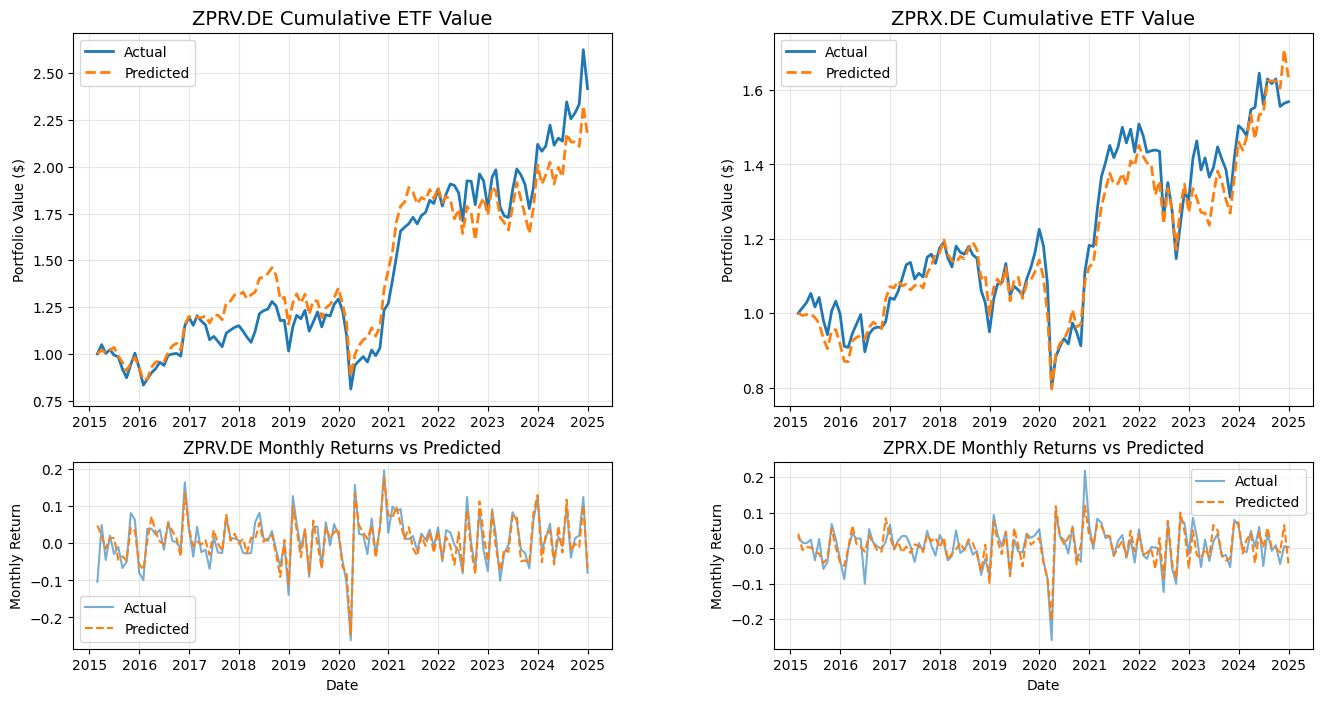

In [52]:
import matplotlib.pyplot as plt

# Prepare predicted returns from Fama-French regressions
predicted_returns = {}
for etf in etf_cols:
    y = ucits_combined[etf] - ucits_combined['RF']
    X = sm.add_constant(ucits_combined[factor_cols])
    model = sm.OLS(y, X).fit()
    # Predicted excess returns + RF to get actual return
    predicted_returns[etf] = model.predict(X) + ucits_combined['RF']

# Colors for plotting
colors = {'Actual':'tab:blue','Predicted':'tab:orange'}

fig, axes = plt.subplots(2, 2, figsize=(16,8), gridspec_kw={'height_ratios':[2,1], 'wspace':0.3})

for i, etf in enumerate(etf_cols):
    actual = ucits_combined[etf].loc[predicted_returns[etf].index]
    pred = predicted_returns[etf]
    
    # -----------------------------
    # Top row: cumulative growth
    # -----------------------------
    cum_actual = (1 + actual).cumprod()
    cum_actual /= cum_actual.iloc[0]  # start at 1
    cum_pred = (1 + pred).cumprod()
    cum_pred /= cum_pred.iloc[0]      # start at 1
    
    axes[0,i].plot(cum_actual.index, cum_actual, color=colors['Actual'], linewidth=2, label='Actual')
    axes[0,i].plot(cum_pred.index, cum_pred, color=colors['Predicted'], linestyle='--', linewidth=2, label='Predicted')
    axes[0,i].set_title(f'{etf} Cumulative ETF Value', fontsize=14)
    axes[0,i].set_ylabel('Portfolio Value ($)')
    axes[0,i].legend()
    axes[0,i].grid(alpha=0.3)
    
    # -----------------------------
    # Bottom row: monthly returns
    # -----------------------------
    axes[1,i].plot(actual.index, actual, color=colors['Actual'], alpha=0.6, label='Actual')
    axes[1,i].plot(pred.index, pred, color=colors['Predicted'], linestyle='--', label='Predicted')
    axes[1,i].set_title(f'{etf} Monthly Returns vs Predicted', fontsize=12)
    axes[1,i].set_ylabel('Monthly Return')
    axes[1,i].set_xlabel('Date')
    axes[1,i].legend()
    axes[1,i].grid(alpha=0.3)

plt.tight_layout()
plt.show()
